In [23]:
#from datetime import datetime, timedelta
from iexfinance.stocks import get_historical_data
from iexfinance.refdata import get_symbols
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import hvplot.pandas
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [12]:
token = os.getenv("IEX_TOKEN")
tickers = pd.DataFrame(get_symbols())
random = tickers.sample(1000)
symbols = random.symbol.to_frame()
symbols.to_csv("Data/symbols1000.csv", index=False)

In [ ]:
index_funds = pd.read_csv("Data/index_funds.csv", index_col="PX_LAST", parse_dates=True, infer_datetime_format=True)

In [ ]:
new_index_funds = index_funds.loc['2018-11-01':'2019-12-01']

In [ ]:
aapl = pd.read_csv("Data/aapl.csv", index_col="date", parse_dates=True, infer_datetime_format=True)
aapl = aapl['close'].to_frame()

In [ ]:
sp500_fundamentals = pd.read_csv("Data/company_fundamentals.csv")
sp500_fundamentals.columns

In [96]:
#import clustering data
sp500_fundamentals = pd.read_csv("Data/Fundamentals_Clustering_12-6-2019.csv")
#sp500_fundamentals = pd.read_csv("Data/company_fundamentals.csv")
sp500_fundamentals = sp500_fundamentals.dropna()
sp500_fundamentals['Ticker'] = sp500_fundamentals.Ticker.apply(lambda x: x[x.find(":")+1:])
sp500_fundamentals = sp500_fundamentals[sp500_fundamentals.IQ_PE_EXCL!='(Invalid Identifier)']

In [97]:
#keep nessessary columns
colnames_keep = sp500_fundamentals.columns[1:]
#colnames_keep =['Ticker', 'PE_Calc', 'Return on Equity_Calc', 'IQ_BETA_2YR']
sp500_fundamentals = sp500_fundamentals[colnames_keep]

In [98]:
#replace 0 and NM values with NA
sp500_fundamentals = sp500_fundamentals.replace("0", np.nan)
sp500_fundamentals = sp500_fundamentals.replace("NM", np.nan)
#sp500_fundamentals = sp500_fundamentals.replace("#DIV/0!", np.nan)


In [99]:
#import industry data
#sp500_industry = pd.read_csv("Data/industry.csv")
sp500_industry = pd.read_csv("Data/s_universe.csv")
#sp500_industry['Ticker'] = sp500_industry.Ticker.apply(lambda x: x[x.find(":")+1:])
sp500_industry.rename(columns={"SPX 8/7/2018":'Ticker'}, inplace=True)
sp500_industry['Ticker'] = sp500_industry.Ticker.str[:-10]
sp500_industry = sp500_industry[['Ticker', 'GICS_SECTOR_NAME']]

In [100]:
#merge industry data and fundamental data
sp500 = pd.merge(sp500_fundamentals, sp500_industry, on="Ticker")
#sp500 = pd.get_dummies(sp500, columns=['Industry'])
labels = sp500['GICS_SECTOR_NAME'].astype('category').cat.categories.tolist()
replace_map_comp = {'GICS_SECTOR_NAME' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
sp500.replace(replace_map_comp, inplace=True)

In [101]:
#get market cap data
sp500_market_cap = pd.read_csv("Data/company_fundamentals.csv")
sp500_market_cap = sp500_market_cap[['Ticker', 'IQ_MarketCap']]
sp500_market_cap['Ticker'] = sp500_market_cap.Ticker.apply(lambda x: x[x.find(":")+1:])
sp500_market_cap.shape

(500, 2)

In [102]:
#merge market cap data
sp500_all = pd.merge(sp500, sp500_market_cap, on="Ticker")
sp500_all.head()

,Ticker,IQ_PE_EXCL,IQ_PE_NORMALIZED,IQ_PBV,IQ_TOTAL_DEBT_EQUITY,IQ_TOTAL_DEBT_CAPITAL,IQ_NI_MARGIN,IQ_NI_NORM_MARGIN,IQ_RETURN_COMMON_EQUITY,IQ_RETURN_ASSETS,IQ_BETA_2YR,IQ_BETA_5YR,GICS_SECTOR_NAME,IQ_MarketCap
0,AAPL,22.76787,30.61689,13.29268,119.4047,54.4221,21.238,15.799,55.9172,11.3473,1.11336,1.22827,8,1.203103e+06
1,MSFT,28.63205,41.02506,10.92258,80.6799,44.6535,31.656,22.0517,42.8,10.6439,1.0719,1.23047,8,1.157290e+06
2,AMZN,77.61561,105.62703,15.3437,132.0007,56.8966,4.2743,3.1373,23.7303,5.2185,1.36685,1.51647,2,8.670105e+05
3,FB,32.1421,39.21898,6.10429,9.7149,8.8547,27.0829,22.1839,20.6698,13.2268,1.21337,1.06229,1,5.767943e+05
4,JPM,13.33257,16.55956,1.79455,NaN,NaN,32.5291,24.8785,14.21,1.3002,1.10356,1.21855,5,4.207901e+05


In [115]:
sp500_all = sp500_all.drop(columns="GICS_SECTOR_NAME")

In [103]:
#fill NAs
def deal_with_na (df, method):
    if method == "ml":
        #drop first column
        first_colname = df.columns[0]
        df = df.drop(columns=first_colname)
        df = df.astype('float')
        #drop rows with more than 2 NAs
        df = df.dropna(thresh=df.shape[1]-1)
        tickers = df.iloc[:,0].to_frame()
        data_without_null = df.dropna() 
        for i in range(0, df.shape[1]):
            print(df.columns[i])
            colname = df.columns[i]
            X_train = data_without_null.drop(columns=[colname])
            y_train = data_without_null[colname]
            X_test = df[df[colname].isnull()].drop(columns=[colname])
            if X_test.shape[0] != 0:
                linreg = LinearRegression()
                linreg.fit(X_train, y_train)
                predicted = linreg.predict(X_test)
                df[colname][df[colname].isnull()] = predicted
        output = pd.concat([tickers, df], axis=1)
        return output
    if method == "ts":
        #drop first column
        tickers = df.iloc[:,0].to_frame()
        first_colname = df.columns[0]
        df = df.drop(columns=first_colname)
        df = df.astype('float')
        for i in range(0, df.shape[1]):
            colname = df.columns[i]
            colmean = df[colname].median()
            df[colname]=df[colname].fillna(colmean)
        output = pd.concat([tickers, df], axis=1)
        return output
        

In [116]:
#sp500_no_na = deal_with_na(sp500_fundamentals, 'ml')
#sp500_no_na = deal_with_na(sp500_fundamentals, 'ts')
#sp500_no_na = sp500_fundamentals.dropna()

#sp500_no_na = deal_with_na(sp500_all, 'ml')
sp500_no_na = deal_with_na(sp500_all, 'ts')
#sp500_no_na = sp500_all.dropna()

#sp500_no_na = deal_with_na(sp500, 'ml')
#sp500_no_na = deal_with_na(sp500, 'ts')
#sp500_no_na = sp500.dropna()
sp500_no_na.head()

,Ticker,IQ_PE_EXCL,IQ_PE_NORMALIZED,IQ_PBV,IQ_TOTAL_DEBT_EQUITY,IQ_TOTAL_DEBT_CAPITAL,IQ_NI_MARGIN,IQ_NI_NORM_MARGIN,IQ_RETURN_COMMON_EQUITY,IQ_RETURN_ASSETS,IQ_BETA_2YR,IQ_BETA_5YR,IQ_MarketCap
0,AAPL,22.76787,30.61689,13.29268,119.4047,54.4221,21.2380,15.7990,55.9172,11.3473,1.11336,1.22827,1.203103e+06
1,MSFT,28.63205,41.02506,10.92258,80.6799,44.6535,31.6560,22.0517,42.8000,10.6439,1.07190,1.23047,1.157290e+06
2,AMZN,77.61561,105.62703,15.34370,132.0007,56.8966,4.2743,3.1373,23.7303,5.2185,1.36685,1.51647,8.670105e+05
3,FB,32.14210,39.21898,6.10429,9.7149,8.8547,27.0829,22.1839,20.6698,13.2268,1.21337,1.06229,5.767943e+05
4,JPM,13.33257,16.55956,1.79455,91.9962,49.5477,32.5291,24.8785,14.2100,1.3002,1.10356,1.21855,4.207901e+05


In [117]:
sp500_kmeans = sp500_no_na.iloc[:,1:]
sp500_kmeans['IQ_MarketCap'] = sp500_kmeans['IQ_MarketCap'].apply(np.log)
sp500_scaled = StandardScaler().fit_transform(sp500_kmeans)

In [118]:
inertia = []
k = list(range(1, 11))
for i in k:
    km = KMeans(n_clusters=i)
    km.fit(sp500_scaled)
    inertia.append(km.inertia_)

elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

:Curve   [k]   (inertia)

In [119]:
model = KMeans(n_clusters=8)
model.fit(sp500_scaled)
predictions = model.predict(sp500_scaled)
predictions = pd.DataFrame(predictions)
predictions.rename(columns={0:'predictions'}, inplace=True)

#predictions = sp500_all['GICS_SECTOR_NAME'].to_frame()
#predictions.rename(columns={'GICS_SECTOR_NAME':'predictions'}, inplace=True)




In [108]:
#sp500_all.shape
sp500_no_na.shape

(464, 14)

In [48]:
output = pd.concat([sp500_no_na, predictions], axis=1)
output.to_csv("Data/clusters.csv", index=False)

In [120]:
#sp500_scaled = StandardScaler().fit_transform(sp500_kmeans)
pca = PCA(n_components=6)
sp500_pca = pca.fit_transform(sp500_scaled)
pca.explained_variance_ratio_

array([0.18607861, 0.15950997, 0.14085805, 0.1203309 , 0.08772602,
       0.07275996])

In [121]:
sp500_pca = pd.DataFrame(
    data=sp500_pca, columns=["pc1", "pc2", 'pc3', 'pc4', 'pc5', 'pc6']
)

sp500_pca_pred = pd.concat([sp500_pca, predictions], axis=1)
sp500_pca_pred.hvplot.scatter(x='pc1', y='pc2', by='predictions', width=800, height=600)

:NdOverlay   [predictions]
   :Scatter   [pc1]   (pc2)

In [ ]:
fig = px.scatter_3d(sp500_pca_pred, x='pc1', y='pc2', z='pc3', color='predictions')
fig.show()

For n_clusters = 2 The average silhouette_score is : 0.20687147394743238
For n_clusters = 3 The average silhouette_score is : 0.15304597372804163
For n_clusters = 4 The average silhouette_score is : 0.1573963661201103
For n_clusters = 5 The average silhouette_score is : 0.17039301085507955
For n_clusters = 6 The average silhouette_score is : 0.17564527716996656
For n_clusters = 7 The average silhouette_score is : 0.18081338642951644
For n_clusters = 8 The average silhouette_score is : 0.1858422572134909


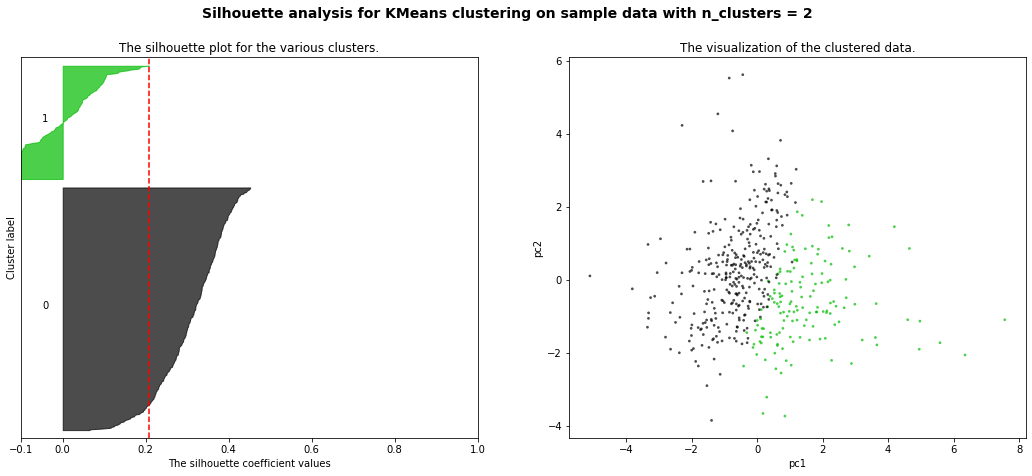

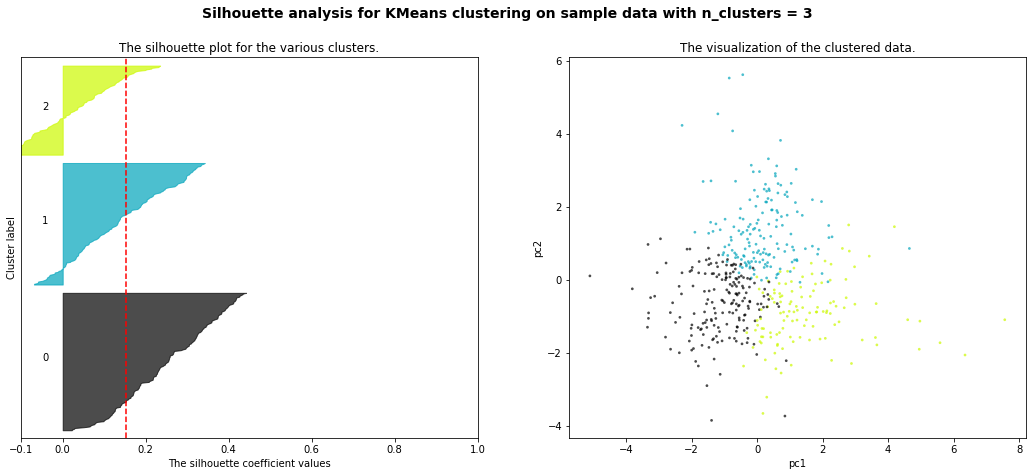

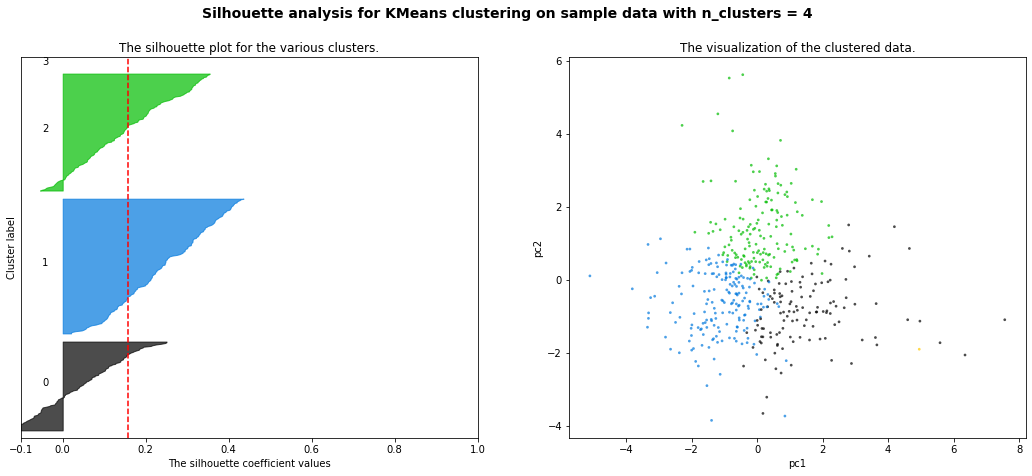

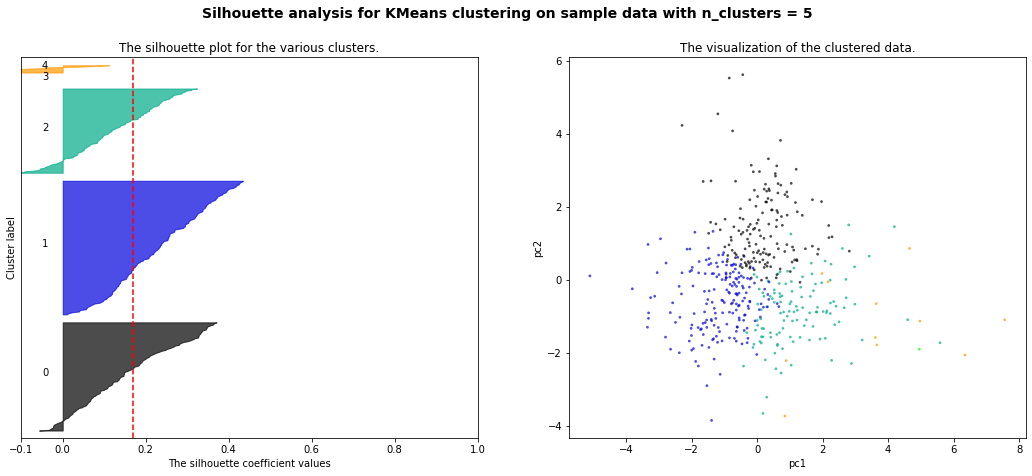

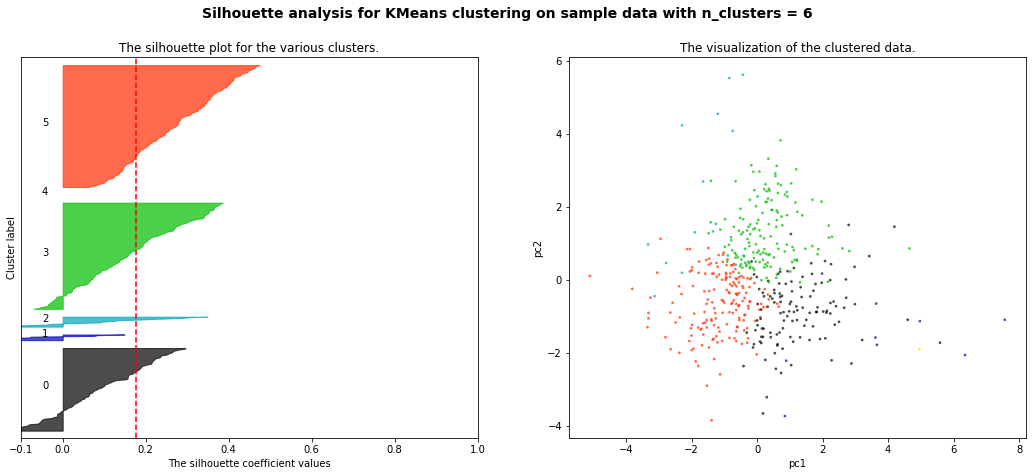

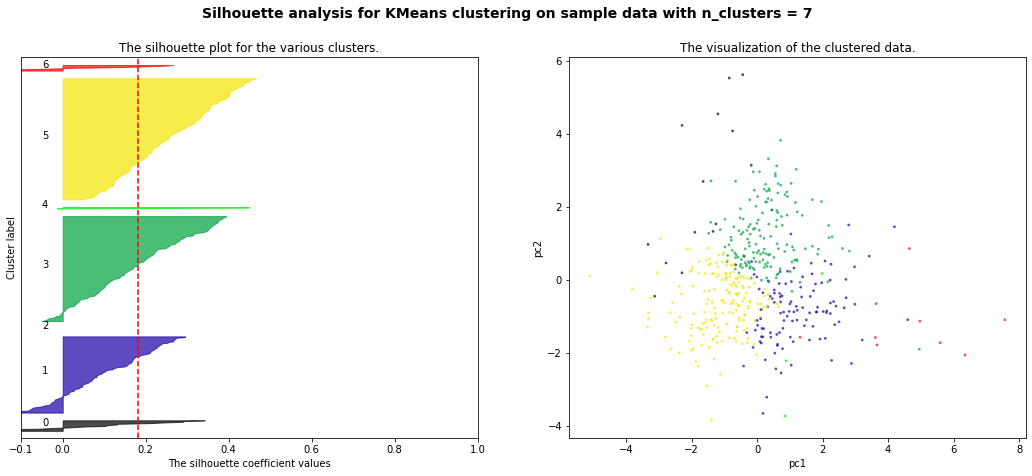

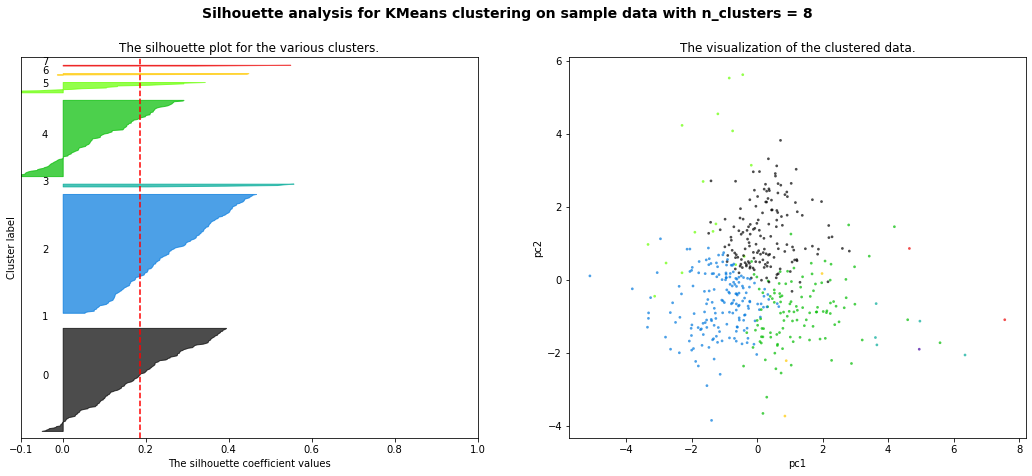

In [122]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(sp500_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(sp500_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(sp500_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(sp500_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(sp500_pca_pred.iloc[:, 0], sp500_pca_pred.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    #ax2.scatter(centers[:, 0], centers[:, 1], marker='o',c="white", alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(centers):
        #ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("pc1")
    ax2.set_ylabel("pc2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    file_name = "Figure/Silhouette_no_industry_" + str(n_clusters) + ".png"
    plt.savefig(file_name)

In [66]:
plt.savefig("Figure/silhouette_no_industry.png")

<Figure size 432x288 with 0 Axes>

In [2]:
#import clusters
clusters = pd.read_csv("Data/clusters.csv")
clusters.groupby('predictions').Ticker.count().to_frame().rename(columns={'Ticker':'Counts'})
#remove clusters
mask1 = clusters['predictions']!=4
mask2 = clusters['predictions']!=6
mask = mask1 & mask2
clusters = clusters[mask]


In [3]:
#import stock prices
stock_prices = pd.read_csv("Data/s_PX.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)
#stock_prices = stock_prices.dropna()
stock_prices.columns = stock_prices.columns.str[:-10]
stock_prices = stock_prices.loc['2018-12-10':'2019-12-10']

In [240]:
stock_prices.head()

,ILMN,EIX,GPS,ES,NLOK,AET,MCO,RMD,LYB,AXP,...,ALGN,ADS,LKQ,NLSN,GRMN,XEC,ZTS,DLR,EQIX,DISCK
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-10,323.05,56.6691,25.7392,67.6708,21.7400,NaN,144.2778,111.4649,80.3329,104.2611,...,216.66,175.677,25.63,24.7575,63.1272,71.324,88.3569,111.2380,379.514,26.40
2018-12-11,328.90,56.7173,25.9206,68.1858,21.9369,NaN,143.9412,112.4917,80.7039,103.8767,...,220.27,174.853,25.31,24.8147,63.5744,71.225,89.2313,111.6586,382.180,25.91
2018-12-12,336.92,57.3433,26.2261,67.4861,22.3997,NaN,146.9307,113.6961,81.2938,105.9267,...,219.29,176.030,25.83,24.8337,64.4300,71.757,90.1555,110.5209,379.553,26.05
2018-12-13,334.62,57.3337,25.4242,68.2441,22.1339,NaN,147.4455,113.8640,79.6193,105.1579,...,217.23,172.223,25.23,24.7099,64.7828,70.446,90.3641,111.2636,381.710,25.99
2018-12-14,326.46,57.4396,25.4051,67.7971,21.2379,NaN,144.0501,111.4945,78.3443,104.1724,...,215.57,169.956,24.60,24.5003,63.8420,67.549,87.8899,110.2605,379.337,26.02


In [4]:
pred = [0,1,2,3,5,7]
cluster_indices = pd.DataFrame()
for cluster in pred:
    tickers = clusters[clusters['predictions']==cluster].Ticker.tolist()
    print(f"cluster size: {len(tickers)}")
    tickers_df = pd.DataFrame(columns=tickers)
    cluster_sp = pd.concat([tickers_df,stock_prices], axis=0, join="inner")
    cluster_sp_no_na = cluster_sp.fillna(cluster_sp.median()).dropna(axis=1, how="all")
    print(f"dataframe size: {cluster_sp_no_na.shape[1]}")
    colnames = cluster_sp_no_na.columns.to_frame().rename(columns={0:"Ticker"})
    marketcap = pd.merge(colnames, clusters, on="Ticker")[['IQ_MarketCap']].astype("float")
    marketcap_weight = (marketcap/marketcap.sum()).IQ_MarketCap.tolist()
    cluster_price = cluster_sp_no_na.dot(marketcap_weight).to_frame().rename(columns={0:cluster})
    cluster_indices = pd.concat([cluster_indices,cluster_price], axis=1)


cluster size: 131
dataframe size: 130
cluster size: 114
dataframe size: 114
cluster size: 131
dataframe size: 131
cluster size: 65
dataframe size: 65
cluster size: 8
dataframe size: 8
cluster size: 11
dataframe size: 11


In [16]:
cluster_indices.to_csv("Data/cluster_index_prices.csv")

In [49]:
pred = [0,1,2,3,5,7]
cluster_pctchange = cluster_indices.pct_change().dropna() * 100
def window_data(df, df2, window_size, colnumber):
    X = []
    y = []
    for i in range(len(df) - window_size):
        features = df.iloc[i : (i + window_size), colnumber]
        target = df2.iloc[(i + window_size), colnumber]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)
    
def window_data2(df, df2, window_size, colnumber):
    X = []
    y = []
    for i in range(len(df) - 2 * window_size):
        features = df.iloc[i : (i + window_size), colnumber]
        rolling = df.iloc[:,colnumber].rolling(window = window_size).mean().dropna()
        X.append(features)
        if rolling[i+window_size] > df2.iloc[i+2*window_size, 0]:
            y.append(1)
        else:
            y.append(0)
    return np.array(X), np.array(y).reshape(-1, 1)   

    
#for cluster in pred:
#    tickers = clusters[clusters['predictions']==cluster].Ticker.tolist()
#    tickers_df = pd.DataFrame(columns=tickers)
#    cluster_sp = pd.concat([tickers_df,stock_prices], axis=0, join="inner")
#    cluster_sp_no_na = cluster_sp.fillna(cluster_sp.median()).dropna(axis=1, how="all").pct_change().dropna() * 100
    

In [46]:
colnumber = 1
rolling = cluster_sp_no_na.iloc[:,colnumber].rolling(window = window_size).mean().dropna()
rolling[2]

-0.5542791811908865

In [50]:
cluster = 0
tickers = clusters[clusters['predictions']==cluster].Ticker.tolist()
tickers_df = pd.DataFrame(columns=tickers)
cluster_sp = pd.concat([tickers_df,stock_prices], axis=0, join="inner")
cluster_sp_no_na = cluster_sp.fillna(cluster_sp.median()).dropna(axis=1, how="all").pct_change().dropna()*100
indices = cluster_pctchange[[cluster]]
column_df = pd.DataFrame(columns = cluster_sp_no_na.columns, index = cluster_sp_no_na.index)
for i in range(0, cluster_sp_no_na.shape[1]):
    column_df.iloc[:,i] = np.where(cluster_sp_no_na.iloc[:,i] > indices.iloc[:,0], 1, 0)
window_size = 5
for i in range(cluster_sp_no_na.shape[1]):
    print(cluster_sp_no_na.columns[i])
    #X, y = window_data(cluster_sp_no_na, column_df, window_size, i)
    X, y = window_data2(cluster_sp_no_na, indices, window_size, i)    
    split = int(0.7 * len(X))
    X_train = X[:split]
    X_test = X[split:]
    y_train = y[:split]
    y_test = y[split:]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    model = Sequential()
    number_units = window_size
    dropout_fraction = 0.2
    # Layer 1
    model.add(LSTM(
        units=number_units,
        return_sequences=True,
        input_shape=(X_train.shape[1], 1))
        )
    model.add(Dropout(dropout_fraction))
    # Layer 2
    model.add(LSTM(units=number_units, return_sequences=True))
    model.add(Dropout(dropout_fraction))
    # Layer 3
    model.add(LSTM(units=number_units))
    model.add(Dropout(dropout_fraction))
    # Output layer
    model.add(Dense(1))
    # Compile the model
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=1, verbose=1)
    model.evaluate(X_test, y_test)

AMZN
Train on 175 samples
Epoch 1/20
175/175 [==============================] - 6s 36ms/sample - loss: 2.2633 - accuracy: 0.4629
Epoch 2/20
175/175 [==============================] - 2s 10ms/sample - loss: 0.9504 - accuracy: 0.4629
Epoch 3/20
175/175 [==============================] - 2s 10ms/sample - loss: 0.7820 - accuracy: 0.4171
Epoch 4/20
175/175 [==============================] - 2s 10ms/sample - loss: 0.7236 - accuracy: 0.5314
Epoch 5/20
175/175 [==============================] - 2s 10ms/sample - loss: 0.7259 - accuracy: 0.5029
Epoch 6/20
175/175 [==============================] - 2s 10ms/sample - loss: 0.7258 - accuracy: 0.5200
Epoch 7/20
175/175 [==============================] - 2s 10ms/sample - loss: 0.7309 - accuracy: 0.4914
Epoch 8/20
175/175 [==============================] - 2s 10ms/sample - loss: 0.7249 - accuracy: 0.5200
Epoch 9/20
175/175 [==============================] - 2s 12ms/sample - loss: 0.6989 - accuracy: 0.5371
Epoch 10/20
175/175 [==========================

KeyboardInterrupt: 

In [21]:
for i in range(0,5):
    print(i)

0
1
2
3
4
